Iteration 9: 100%|██████████| 50/50 [00:11<00:00,  4.42it/s, episode=500, return=45.519] 


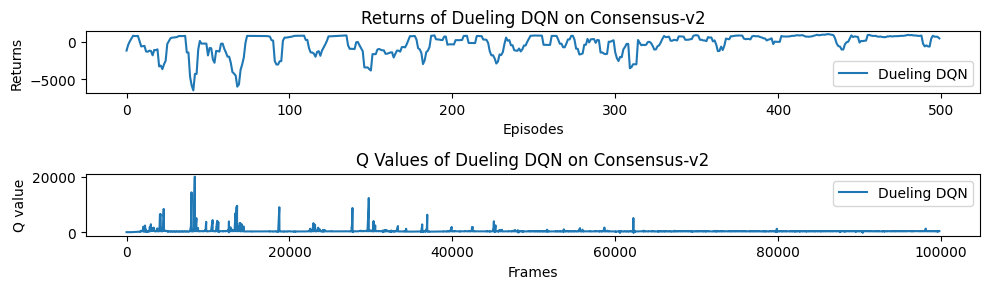

In [7]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import random
import numpy as np

# 经验回放和优先级经验回放的相关类，保持不变

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, value):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:
                if value <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    value -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=1e-5):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.tree = SumTree(capacity)
        self.max_priority = 1.0

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        priority = self.max_priority
        self.tree.add(priority, data)

    def sample(self, batch_size):
        batch = []
        indexes = []
        is_weights = []
        segment = self.tree.tree[0] / batch_size
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            value = random.uniform(a, b)
            index, priority, data = self.tree.get_leaf(value)
            
            # 使用优先级计算采样概率，并计算 is_weight
            prob = priority / self.tree.tree[0]
            is_weight = np.power(len(self.tree.data) * prob, -self.beta)  # 修正为访问 self.tree.data
            is_weights.append(is_weight)
            indexes.append(index)
            batch.append(data)

        # 更新 beta，使其在训练过程中逐渐增大
        self.beta = np.min([1.0, self.beta + self.beta_increment])

        # 对 is_weights 进行归一化
        is_weights = np.array(is_weights) / max(is_weights)

        return batch, indexes, is_weights

    def update_priorities(self, index, td_error):
        priority = np.abs(td_error) + 1e-6  # 添加一个小常数以避免零优先级
        priority = min(priority, self.max_priority)
        self.max_priority = max(self.max_priority, priority)
        self.tree.update(index, priority)

    def size(self):
        return self.tree.data_pointer


# 定义Dueling DQN的网络架构
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)  # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q


# DQN类，主要部分保持不变
class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, dqn_type='DuelingDQN'):
        self.action_dim = action_dim
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size)
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):  # 计算给定状态的最大Q值
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        is_weights = torch.tensor(transition_dict['is_weights'], dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        td_errors = q_targets - q_values

        # 更新优先级缓冲区中的每个样本的优先级
        for i in range(len(transition_dict['dones'])):
            index = transition_dict['indexes'][i]
            self.replay_buffer.update_priorities(index, td_errors[i].item())

        # 计算带有权重的损失
        dqn_loss = torch.mean(is_weights * F.mse_loss(q_values, q_targets, reduction='none'))
        
        # 梯度清零
        self.optimizer.zero_grad()
        # 反向传播
        dqn_loss.backward()
        # 更新网络权重
        self.optimizer.step()

        # 更新目标网络参数
        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


# 超参数设置
lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 10
buffer_size = 5000
minimal_size = 10
batch_size = 32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_name = 'Consensus-v2'
env = gym.make(env_name)
state_dim = 5
action_dim = 32

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        batch, indexes, is_weights = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': [item[0] for item in batch],
                            'actions': [item[1] for item in batch],
                            'rewards': [item[2] for item in batch],
                            'next_states': [item[3] for item in batch],
                            'dones': [item[4] for item in batch],
                            'indexes': indexes,
                            'is_weights': is_weights  # 传递 is_weights
                        }
                        agent.update(transition_dict)

                        # 计算当前状态的 Q 值并将其添加到 max_q_value_list
                        current_q_value = agent.max_q_value(state)
                        max_q_value_list.append(current_q_value)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

# 设定随机种子
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 实例化经验池
replay_buffer = PrioritizedReplayBuffer(buffer_size)

# 创建Dueling DQN代理
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DuelingDQN')
return_list_dueling, max_q_value_list_dueling = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

# 绘制收益和Q值图像
episodes_list = list(range(len(return_list_dueling)))
mv_return_dueling = rl_utils.moving_average(return_list_dueling, 5)

# 绘制图形
plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(episodes_list, mv_return_dueling, label='Dueling DQN')
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Returns of Dueling DQN on {}'.format(env_name))
plt.legend()
plt.show()

# 绘制Q值变化
frames_list = list(range(len(max_q_value_list_dueling)))
plt.subplot(2, 1, 2)
plt.plot(frames_list, max_q_value_list_dueling, label='Dueling DQN') 
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Q Values of Dueling DQN on {}'.format(env_name))
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

# 经验回放和优先级经验回放的相关类，保持不变

class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, value):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:
                if value <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    value -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=1e-5):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = beta_increment
        self.tree = SumTree(capacity)
        self.max_priority = 1.0

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        priority = self.max_priority
        self.tree.add(priority, data)

    def sample(self, batch_size):
        batch = []
        indexes = []
        is_weights = []
        segment = self.tree.tree[0] / batch_size
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            value = random.uniform(a, b)
            index, priority, data = self.tree.get_leaf(value)

            prob = priority / self.tree.tree[0]
            is_weight = np.power(len(self.tree.data) * prob, -self.beta)
            is_weights.append(is_weight)
            indexes.append(index)
            batch.append(data)

        self.beta = np.min([1.0, self.beta + self.beta_increment])
        is_weights = np.array(is_weights) / max(is_weights)

        return batch, indexes, is_weights

    def update_priorities(self, index, td_error):
        priority = np.abs(td_error) + 1e-6
        priority = min(priority, self.max_priority)
        self.max_priority = max(self.max_priority, priority)
        self.tree.update(index, priority)

    def size(self):
        return self.tree.data_pointer


# 定义带有LSTM的Dueling DQN网络架构
class VAnetLSTM(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnetLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(state_dim, hidden_dim, batch_first=True)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # 获取LSTM最后一个时间步的输出

        A = self.fc_A(F.relu(lstm_out))
        V = self.fc_V(F.relu(lstm_out))
        Q = V + A - A.mean(1).view(-1, 1)
        return Q


# 定义不带LSTM的Dueling DQN网络架构
class VAnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)
        return Q


# DQN类
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device, dqn_type='DuelingDQN', use_lstm=False):
        self.action_dim = action_dim
        self.replay_buffer = PrioritizedReplayBuffer(buffer_size)
        self.use_lstm = use_lstm
        
        if use_lstm:
            self.q_net = VAnetLSTM(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = VAnetLSTM(state_dim, hidden_dim, self.action_dim).to(device)
        else:
            self.q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim, self.action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)

        if self.use_lstm:
            state = state.unsqueeze(1)

        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)

        if self.use_lstm:
            state = state.unsqueeze(1)

        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        is_weights = torch.tensor(transition_dict['is_weights'], dtype=torch.float).view(-1, 1).to(self.device)

        if self.use_lstm:
            states = states.unsqueeze(1)
            next_states = next_states.unsqueeze(1)

        q_values = self.q_net(states).gather(1, actions)
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        td_errors = q_targets - q_values

        for i in range(len(transition_dict['dones'])):
            index = transition_dict['indexes'][i]
            self.replay_buffer.update_priorities(index, td_errors[i].item())

        dqn_loss = torch.mean(is_weights * F.mse_loss(q_values, q_targets, reduction='none'))
        
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


# 超参数设置
lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 10
buffer_size = 5000
minimal_size = 20
batch_size = 32
use_lstm = True  # 设置是否使用LSTM
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
env_name = 'Consensus-v2'
env = gym.make(env_name)
state_dim = 5
action_dim = 32

def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
    max_q_value_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        batch, indexes, is_weights = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': [item[0] for item in batch],
                            'actions': [item[1] for item in batch],
                            'rewards': [item[2] for item in batch],
                            'next_states': [item[3] for item in batch],
                            'dones': [item[4] for item in batch],
                            'indexes': indexes,
                            'is_weights': is_weights
                        }
                        agent.update(transition_dict)

                        current_q_value = agent.max_q_value(state)
                        max_q_value_list.append(current_q_value)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return': '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

# 设定随机种子
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# 实例化经验池
replay_buffer = PrioritizedReplayBuffer(buffer_size)

# 创建Dueling DQN代理
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device, 'DuelingDQN', use_lstm)
return_list_dueling, max_q_value_list_dueling = train_DQN(agent, env, num_episodes, replay_buffer, minimal_size, batch_size)

# 绘制收益和Q值图像
episodes_list = list(range(len(return_list_dueling)))
mv_return_dueling = rl_utils.moving_average(return_list_dueling, 5)

plt.figure(figsize=(10, 3))
plt.subplot(2, 1, 1)
plt.plot(episodes_list, mv_return_dueling, label='Dueling DQN')
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Returns of Dueling DQN on {}'.format(env_name))
plt.legend()

frames_list = list(range(len(max_q_value_list_dueling)))
plt.subplot(2, 1, 2)
plt.plot(frames_list, max_q_value_list_dueling, label='Dueling DQN')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Q Values of Dueling DQN on {}'.format(env_name))
plt.legend()
plt.tight_layout()
plt.show()

Iteration 0:  84%|████████▍ | 42/50 [00:17<00:03,  2.37it/s, episode=40, return=435.679] 


KeyboardInterrupt: 